# Generation of analysis data for tests

In [1]:
import gromacs
import mdtraj as md
import mdenvironment as mde

print(f'GROMACS version used to generate data: {gromacs.release}')
print(f'MDTraj version used to generate data: {md.version.full_version}')
print(f'MDEnvironment version used to run this notebook: {mde.__version__}')

Numba version  0.53.1  detected. MDEnvironment will default to optimization using Numba.

Numba currently using 4 threads with shared memory! Reduce this number by passing "numba.set_num_threads(x)" with an appropriate integer value.

GROMACS version used to generate data: 2021.3-MODIFIED
MDTraj version used to generate data: 1.9.6
MDEnvironment version used to run this notebook: 0.0.1


In [2]:
infiles = 'nacl_box'
ref = 'O'
sel = 'O'
n_bins = 120
r_max = 1.2  # 2 nm
bin_width = r_max / n_bins
gmx_rmax = r_max + bin_width / 2

run = {
    'GROMACS': True,
    'MDTraj': True,
    'MDEnvironment': True
}

## GROMACS RDF

Run the following command in GROMACS (but here using the GROMACS-wrapper):

```bash
gmx rdf -f nacl_box -s nacl_box -n nacl_box -o -cn -ref "O" -sel "O"
```

In [3]:
if run['GROMACS']:
    import gromacs
    %time gromacs.g_rdf('o', 'nobackup', f=infiles, s=infiles, n=infiles, ref=ref, sel=sel, cut=bin_width/2, rmax=gmx_rmax, bin=bin_width)

                   :-) GROMACS - gmx rdf, 2021.3-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teemu


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

CPU times: user 45.3 ms, sys: 9.67 ms, total: 55 ms
Wall time: 13.4 s


Last frame        200 time    2.000   
Analyzed 201 frames, last time 2.000

GROMACS reminds you: "We mathematicians are all a bit crazy." (Lev Landau)



In [4]:
from gromacs.formats import XVG

gmx_rdf = XVG(f'rdf.xvg').to_df()
gmx_rdf

,r (nm),O
0,0.00,0.000
1,0.01,0.000
2,0.02,0.000
3,0.03,0.000
4,0.04,0.000
...,...,...
116,1.16,1.005
117,1.17,1.003
118,1.18,1.003
119,1.19,1.001


In [5]:
import numpy as np

gmx_r, gmx_gr = np.loadtxt('rdf.xvg', comments=['#', '@'], unpack=True)

## RDF using MDTraj


In [6]:
if run['MDTraj'] or run['MDEnvironment']:
    import mdtraj as md

    top = md.load_topology('nacl_box.gro')
    traj = md.load('nacl_box.xtc', top=top)
    groups = {g: traj.top.select(f'name {g}') for g in ['O', 'NA', 'CL', 'H']}

    oxygen_pairs = traj.top.select_pairs(groups['O'], groups['O'])

In [7]:
import numpy as np

if run['MDTraj']:
    %time mdtraj_r, mdtraj_gr = md.compute_rdf(traj, pairs=oxygen_pairs, periodic=True, opt=True, n_bins=n_bins, r_range=(0, r_max))
    np.savetxt('mdtraj_r.txt', mdtraj_r)
    np.savetxt('mdtraj_gr.txt', mdtraj_gr)

else:
    mdtraj_r = np.loadtxt('mdtraj_r.txt')
    mdtraj_gr = np.loadtxt('mdtraj_gr.txt')

CPU times: user 8.23 s, sys: 2.35 s, total: 10.6 s
Wall time: 12.2 s


## RDF from MDEnvironment using the `grt` time-resolved RDF method
We'll just average over the time windows to give us the same result as the static RDF over the whole trajectory.

In [8]:
if run['MDEnvironment']:
    from numba import set_num_threads
    set_num_threads(2)
    import mdenvironment as mde

    r, grt = mde.grt('nacl_box.xtc', groups['O'], groups['O'], pbc='ortho', opt=True, top=top,
                     n_windows=10, window_size=20, stride=1, skip=0, r_range=(0.0, r_max), nbins=n_bins)

    np.savetxt('mdenv_r.txt', r)
    gr = grt.mean(axis=(0,1,2))
    np.savetxt('mdenv_gr.txt', gr)

else:
    r = np.loadtxt('mdenv_r.txt')
    gr = np.loadtxt('mdenv_gr.txt')

Progress over trajectory: 100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


## RDF from MDEnvironment using the `Grt` van Hove function (VHF) method for the distinct part (excluding self-correlation)
To check the correct behaviour, at least with respect to the norm, we can put windows of size 1 (frame) over the whole
trajectory, thus giving us the static RDF over the whole trajectory.

In [9]:
if run['MDEnvironment']:
    from numba import set_num_threads
    set_num_threads(2)
    import mdenvironment as mde

    vhf_r, vhf_grt = mde.vanhove('nacl_box.xtc', groups['O'], groups['O'], pbc='ortho', opt=True, top=top,
                                 n_windows=200, window_size=1, stride=1, skip=0, r_range=(0.0, r_max), nbins=n_bins)

    np.savetxt('vhf_r.txt', vhf_r)
    vhf_gr = vhf_grt.mean(axis=(0,1,2))
    np.savetxt('vhf_gr.txt', vhf_gr)

else:
    vhf_r = np.loadtxt('vhf_r.txt')
    vhf_gr = np.loadtxt('vhf_gr.txt')

Progress over trajectory: 100%|██████████| 200/200 [00:28<00:00,  7.03it/s]


## Plot results and differences
We'll see that due to the binning, the values from GROMACS will differ slightly. MDEnvironment's functions should be
identical to those given by MDTraj.

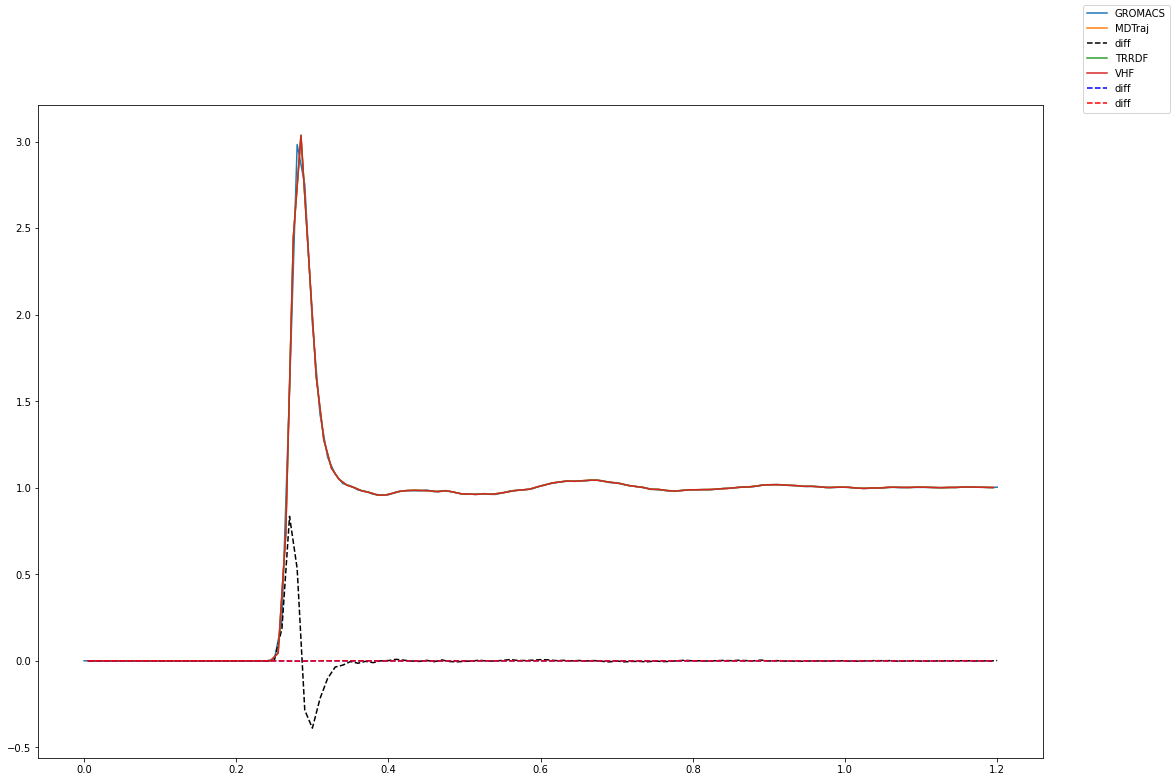

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,12))

ax.plot(gmx_rdf['r (nm)'], gmx_rdf['O'], label='GROMACS')
ax.plot(mdtraj_r, mdtraj_gr, label='MDTraj')
ax.plot(gmx_rdf['r (nm)'][1:], gmx_rdf['O'][1:] - mdtraj_gr, 'k--', label='diff')
ax.plot(r, gr, label='TRRDF')
ax.plot(vhf_r, vhf_gr, label='VHF')
ax.plot(r, gr - mdtraj_gr, 'b--', label='diff')
ax.plot(vhf_r, vhf_gr - mdtraj_gr, 'r--', label='diff')

fig.legend()

## Numerical comparison
Let's check if the data is truly identical within numerical precision, or an acceptable deviation.

In [11]:
def compare_arrays(a, b, atol=1e-2):
    try:
        np.testing.assert_allclose(a, b, atol=1e-2)
        print(f'All elements match within absolute tolerance of {atol}!')
    except AssertionError as err:
        print(err)

### MDTraj vs GROMACS

In [12]:
compare_arrays(mdtraj_gr, gmx_rdf['O'][1:])


Not equal to tolerance rtol=1e-07, atol=0.01

Mismatched elements: 11 / 120 (9.17%)
Max absolute difference: 0.83462684
Max relative difference: 0.93683134
 x: array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,...
 y: array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.005, 0.231, 1.567,...


### MDTraj vs TRRDF

In [13]:
compare_arrays(mdtraj_gr, gr)

All elements match within absolute tolerance of 0.01!


### MDTraj vs VHF

In [14]:
compare_arrays(mdtraj_gr, vhf_gr)

All elements match within absolute tolerance of 0.01!


### Using Numpy to load GROMACS xvg data

In [15]:
compare_arrays(gmx_rdf['r (nm)'], gmx_r)
compare_arrays(gmx_rdf['O'], gmx_gr)

All elements match within absolute tolerance of 0.01!
All elements match within absolute tolerance of 0.01!


## Trapezoid integration

In [16]:
def print_trapz(a, name):
    print(f'Integral of {name}: {np.trapz(a)}')

print_trapz(gmx_rdf['O'], 'gmx rdf')
print_trapz(mdtraj_gr, 'MDTraj compute_rdf')
print_trapz(gr, 'MDEnvironment grt')
print_trapz(vhf_gr, 'vanhove')

Integral of gmx rdf: 99.5165
Integral of MDTraj compute_rdf: 99.05880518436805
Integral of MDEnvironment grt: 99.0126953125
Integral of MDEnvironment Grt: 99.01264190673828
